In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import time as datetime

from siphon.catalog import TDSCatalog
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [ ]:
def load_datasets(year, month, start_day, start_hour=0, end_day=None, end_hour=23):
    # Set end_day to start_day if not provided
    if end_day is None:
        end_day = start_day
    
    # Get the last day of the month
    last_day_of_month = pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(1)
    last_day_str = f"{last_day_of_month.day:02d}"  # format last day as two digits

    # Format date and time strings
    year_month = f'{year}{month:02d}'
    start_time = f'{year}{month:02d}{start_day:02d}{start_hour:02d}'  # yyyymmddhh (start)
    end_time = f'{year}{month:02d}{end_day:02d}{end_hour:02d}'  # yyyymmddhh (end)

    # Define URLs for pressure level datasets with specific time ranges
    urls = {
        'temperature_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_130_t.ll025sc.{start_time}_{end_time}.nc',
        'geopotential_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_129_z.ll025sc.{start_time}_{end_time}.nc',
        'humidity_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_133_q.ll025sc.{start_time}_{end_time}.nc',
        'v_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_132_v.ll025uv.{start_time}_{end_time}.nc',
        'u_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_131_u.ll025uv.{start_time}_{end_time}.nc',
        'w_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_135_w.ll025sc.{start_time}_{end_time}.nc',
        'pv_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_060_pv.ll025sc.{start_time}_{end_time}.nc',
        
        # Define URLs for surface datasets to cover the full month using last_day_of_month
        'mslp_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_151_msl.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc'}

    # Initialize empty dictionaries for datasets
    datasets = {}

    # Try to load datasets from the URLs
    for var, url in urls.items():
        try:
            tds_catalog = TDSCatalog(url)
            ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
            ds = xr.open_dataset(ds_url).metpy.parse_cf()
            datasets[var] = ds
            print("="*50)
            print(f"Successfully loaded {var}")
            print("="*50)

        except Exception as e:
            print("="*50)
            print(f"Error loading {var}: {e}")
            print("="*50)

    # Merge pressure level datasets if available
    ds_pl, ds_sfc, ds_lsm = None, None, None

    try:
        ds_pl = xr.merge([datasets['temperature_pl'], datasets['geopotential_pl'], datasets['humidity_pl'], 
                        datasets['v_wind_pl'], datasets['u_wind_pl'], datasets['w_wind_pl'], datasets['pv_pl']])
        print("="*50)
        print("Successfully merged pressure level datasets")
        print("="*50)
    except KeyError as e:
        print("="*50)
        print(f"Error merging pressure level datasets: {e}")
        print("="*50)

    # Merge surface datasets if available
    try:
        ds_sfc = xr.merge([datasets['mslp_sfc']])
        print("="*50)
        print("Successfully merged surface datasets")
        print("="*50)
    except KeyError as e:
        print("="*50)
        print(f"Error merging surface datasets: {e}")
        print("="*50)

    # Load the land-sea mask
    try:
        lsm_url = 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.invariant/197901/catalog.html?dataset=files/g/d633000/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
        tds_catalog = TDSCatalog(lsm_url)
        ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
        ds = xr.open_dataset(ds_url).metpy.parse_cf()
        ds_lsm = ds['LSM'].isel(time=0)
        print("="*50)
        print("Successfully loaded land-sea mask")
        print("="*50)
    except Exception as e:
        print("="*50)
        print(f"Error loading land-sea mask: {e}")
        print("="*50)

    # Synchronize time dimensions
    try:
        if ds_pl is not None and ds_sfc is not None:
            first_time_pl, last_time_pl = ds_pl['time'].min().values, ds_pl['time'].max().values
            ds_sfc = ds_sfc.sel(time=slice(first_time_pl, last_time_pl))
    except KeyError as e:
        print("="*50)
        print(f"Error accessing 'time' in the datasets: {e}")
        print("="*50)
    except Exception as e:
        print("="*50)
        print(f"An error occurred during slicing: {e}")
        print("="*50)
        
    return ds_pl, ds_sfc, ds_lsm

def theta_pv_cross_section(start_point, end_point, ds_pl, directions, g):
    # Loop over the reanalysis time steps
    for i in range(0, len(ds_pl.time.values)):
        iteration_start = datetime.time()
        ds_pl_sliced = ds_pl.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Get the u, v, t, and q fields at multiple levels
        u_sliced = ds_pl_sliced['U'].sel(level=slice(150, 1000)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(150, 1000)) # units: m/s
        t_sliced = ds_pl_sliced['T'].sel(level=slice(150, 1000)) # units: K
        q_sliced = ds_pl_sliced['Q'].sel(level=slice(150, 1000)) # units: kg/kg
        pressure_levels = t_sliced['level'] # units: 
        pressure_levels_ivt = u_sliced.level[::-1] * 100 # units: Pa

        # Calculate potential temperature
        theta = mpcalc.potential_temperature(pressure_levels, t_sliced) # units: K

        # Add the potential temperature (theta) to the dataset
        theta_da = xr.DataArray(theta, dims=['level', 'latitude', 'longitude'],
                                coords={'level': t_sliced['level'], 
                                        'latitude': t_sliced['latitude'], 
                                        'longitude': t_sliced['longitude']},
                                attrs={'units': 'K'})

        ds_pl_sliced['THETA'] = theta_da

        lats = u_sliced['latitude'][:]
        lons = u_sliced['longitude'][:] 


        # Calculate the integrated vapor transport (IVT) using the u- and v-wind components and the specific humidity
        u_ivt = -1 / g * np.trapz(u_sliced * q_sliced, pressure_levels_ivt, axis=0)
        v_ivt = -1 / g * np.trapz(v_sliced * q_sliced, pressure_levels_ivt, axis=0)

        # Calculate the IVT magnitude
        ivt = np.sqrt(u_ivt**2 + v_ivt**2)

        # Create an xarray DataArray for the IVT
        ivt_da = xr.DataArray(ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IVT plot
        ivt_levels = [250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600, 1800]
        ivt_colors = ['#ffff00', '#ffe400', '#ffc800', '#ffad00', '#ff8200', '#ff5000', '#ff1e00', '#eb0010', '#b8003a', '#850063', '#570088']
        ivt_cmap = mcolors.ListedColormap(ivt_colors)
        ivt_norm = mcolors.BoundaryNorm(ivt_levels, ivt_cmap.N)

        # Mask the IVT values below 250 kg/m/s and create a filtered DataArray for the u- and v-wind components
        mask = ivt_da >= 250
        u_ivt_filtered = xr.DataArray(u_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)
        v_ivt_filtered = xr.DataArray(v_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Now do the cross-section interpolation
        lat_values = np.linspace(start_point[0], end_point[0])
        lon_values = np.linspace(start_point[1], end_point[1])
        x = xr.DataArray(lon_values, dims='Lat_Lon')
        y = xr.DataArray(lat_values, dims='Lat_Lon')
        
        # Interpolate the sliced data for the cross-section
        ds_cross = ds_pl_sliced.interp(longitude=x, latitude=y, method='nearest')

        # Get the temperature, potential vorticity, and theta 
        pv_crossed = ds_cross['PV'].sel(level=slice(150, 1000)) # units: K
        theta_crossed = ds_cross['THETA'].sel(level=slice(150, 1000)) # units: K
        #fgen_crossed = ds_cross['FGEN'].sel(level=slice(150, 1000)) # units: K / 100km / hr

        # Get the pressure levels
        pressure_levels = pv_crossed['level'] # units: hPa

        # Define the color levels and colors for the potential vorticity
        levels = np.arange(0, 3.26, 0.25)
        colors = ['white', '#d1e9f7', '#a5cdec', '#79a3d5', '#69999b', '#78af58', '#b0cc58', '#f0d95f', '#de903e', '#cb5428', '#b6282a', '#9b1622', '#7a1419']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Smooth the PV and potential temperature 
        pv_smoothed = gaussian_filter(pv_crossed, sigma=1)
        theta_smoothed = gaussian_filter(theta_crossed, sigma=1)

        # Create the figure 
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the isentropes and potential vorticity 
        isentropes = ax.contour(ds_cross['longitude'], pressure_levels, theta_smoothed, colors='black', levels=np.arange(250, 450, 1))
        ax.clabel(isentropes, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        pv_cf = ax.contourf(ds_cross['longitude'], pressure_levels, pv_smoothed * 1e6, cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(pv_cf, orientation='vertical', label='PV (m$^2$ s$^{-1}$ K kg$^{-1}$)', fraction=0.046, pad=0.04)


        # Adding the isentropes to the legend with a custom label
        theta_line = plt.Line2D([0], [0], color='black', linewidth=1, label=r'$\theta$ Potential Temperature (K)')

        # Creating the legend with the custom entries
        ax.legend(handles=[theta_line], loc='upper right')
        ax.set_yticks(pressure_levels)
        ax.set_yticklabels(list(pressure_levels.values))
        plt.ylim(1000, 600)
        plt.xlabel('Longitude (degrees E)')
        plt.ylabel('Pressure (hPa)')
        plt.title(f'ERA5 Reanalysis Vertical Cross-Section of PV and $\\theta$ | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}')

        # Manually set y-axis tick marks
        custom_ticks = [1000, 900, 800, 700, 600]  
        ax.set_yticks(custom_ticks)
        ax.set_yticklabels([str(tick) for tick in custom_ticks])

        # Add labels A and A' labels
        ax.text(0, -0.1, 'A', transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='left', fontweight='bold')
        ax.text(1, -0.1, "A'", transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')

        # Add an inset of the plan view to provide additional context 
        ax_inset = fig.add_axes([0.10, 0.63, 0.25, 0.25], projection=ccrs.PlateCarree())
        ax_inset.set_extent([directions['East'], directions['West'], directions['South'], directions['North']])
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.OCEAN, color='white')
        ax_inset.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax_inset.add_feature(cfeature.LAND, color='#fbf5e9')
        ax_inset.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]],
                            color="black", marker="o", transform=ccrs.PlateCarree())
        # Add text annotations
        ax_inset.text(start_point[1], start_point[0], "A", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)
        ax_inset.text(end_point[1], end_point[0], "A'", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)

        c = ax_inset.contour(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), colors='black', levels=ivt_levels, linewidths=0.5)
        cf = ax_inset.contourf(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), cmap=ivt_cmap, levels=ivt_levels, norm=ivt_norm, extend='max')

        # Plot the IVT vectors
        step = 5 
        plt.quiver(u_ivt_filtered['longitude'][::step], u_ivt_filtered['latitude'][::step], u_ivt_filtered[::step, ::step], v_ivt_filtered[::step, ::step], scale=500,scale_units='xy', color='black')
        plt.show()

        iteration_end = datetime.time()
        print("="*50)
        print(f"Time taken for iteration {i}: {iteration_end - iteration_start:.2f} seconds")
        print("="*50)

Loading datasets...


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded temperature_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded geopotential_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded humidity_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_135_w.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_135_w.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded w_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded pv_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded mslp_sfc
Successfully merged pressure level datasets
Successfully merged surface datasets


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.invariant/197901/catalog.html?dataset=files/g/d633000/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.invariant/197901/catalog.xml?dataset=files/g/d633000/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded land-sea mask
Datasets loaded successfully.
Making cross-sections...


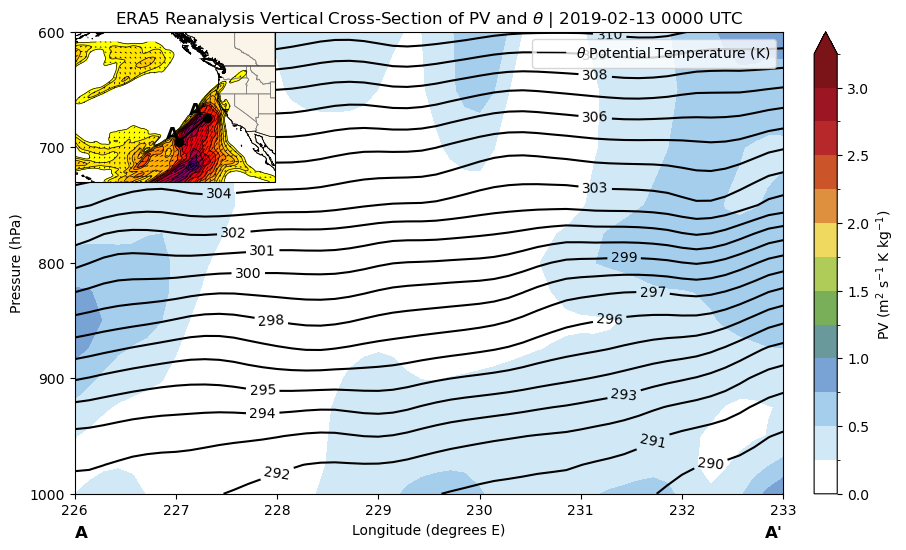

Time taken for iteration 0: 14.94 seconds


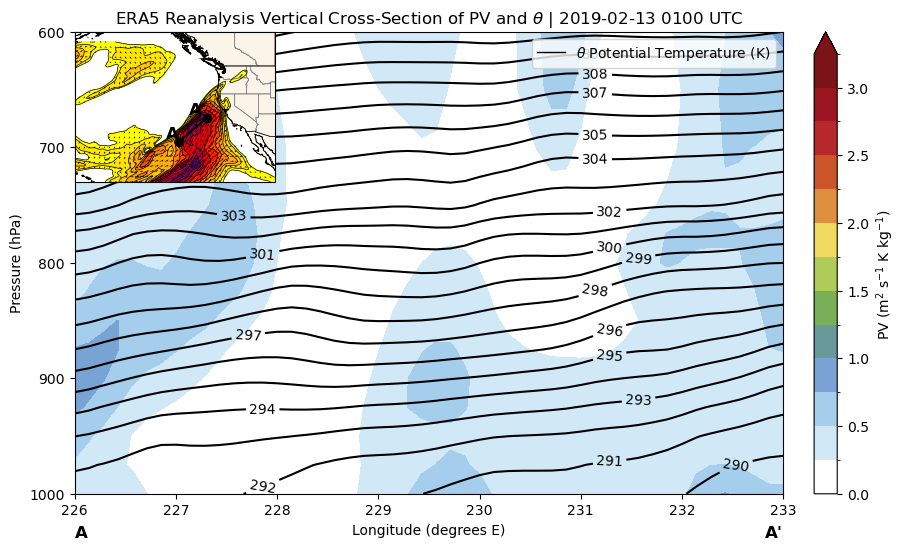

Time taken for iteration 1: 13.65 seconds


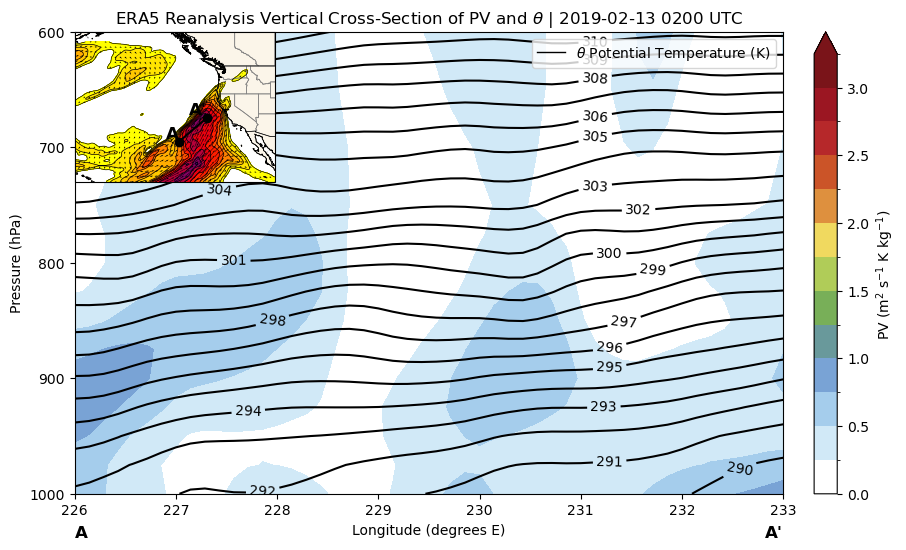

Time taken for iteration 2: 15.32 seconds


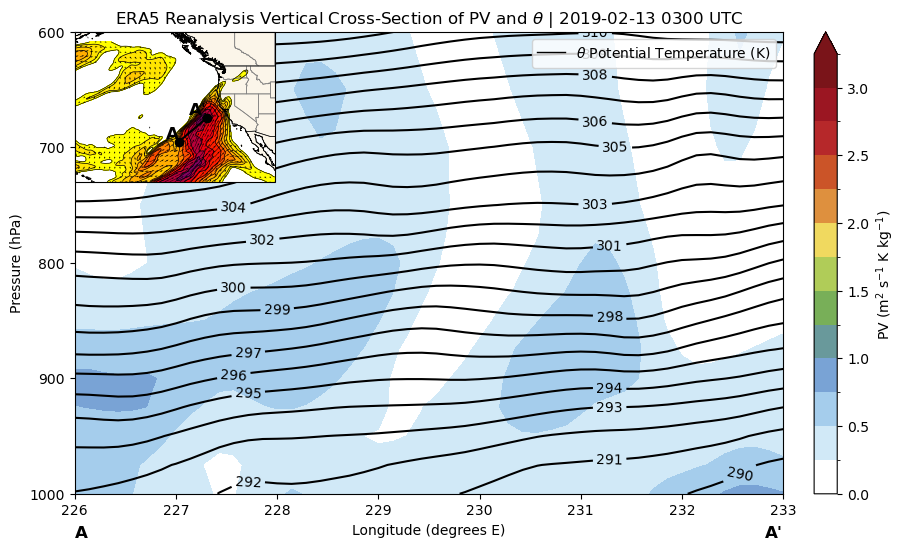

Time taken for iteration 3: 14.01 seconds


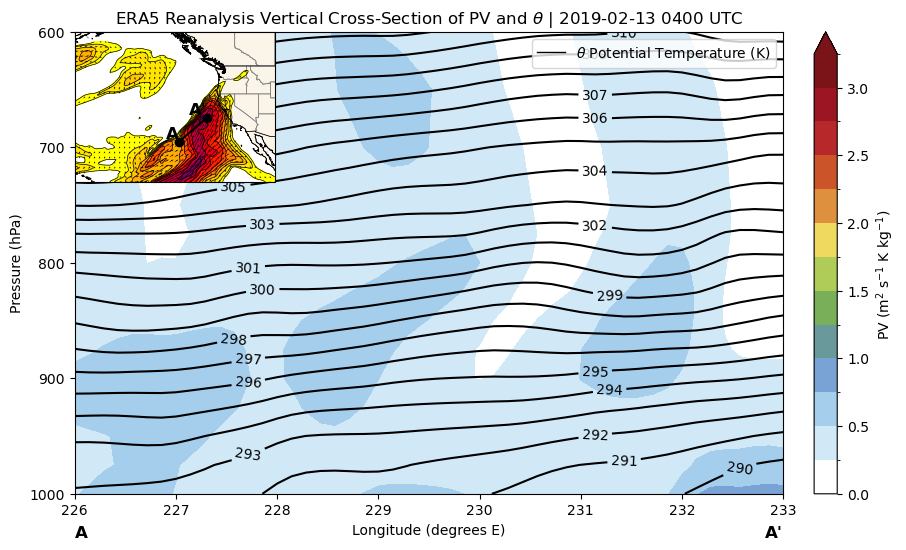

Time taken for iteration 4: 14.17 seconds


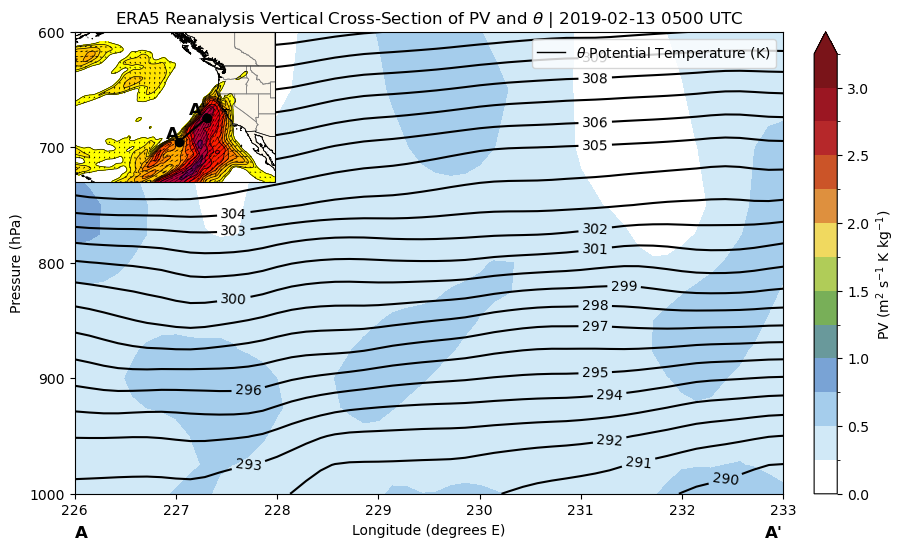

Time taken for iteration 5: 14.41 seconds


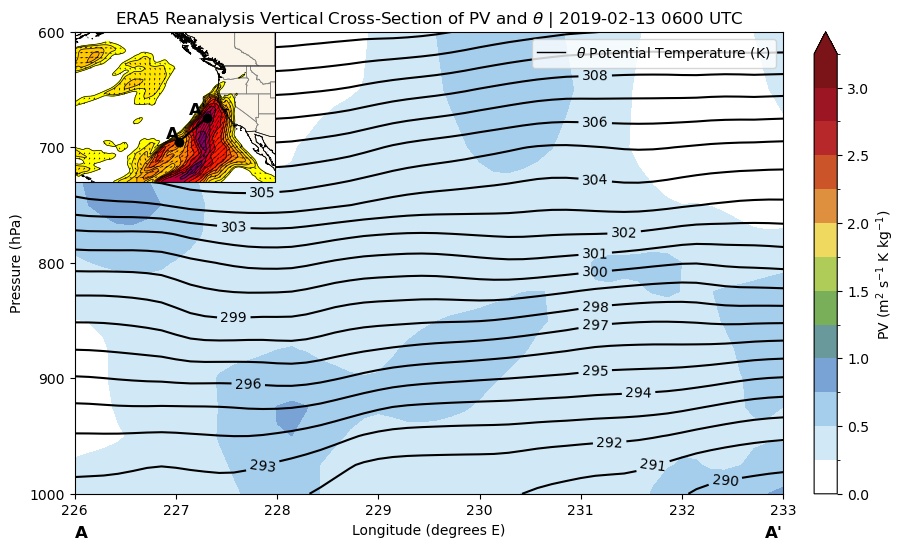

Time taken for iteration 6: 14.82 seconds


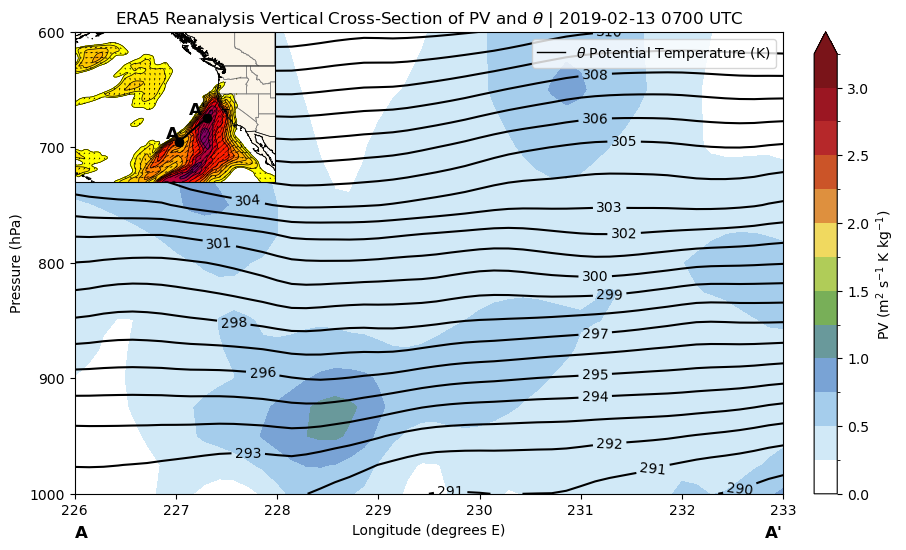

Time taken for iteration 7: 15.37 seconds


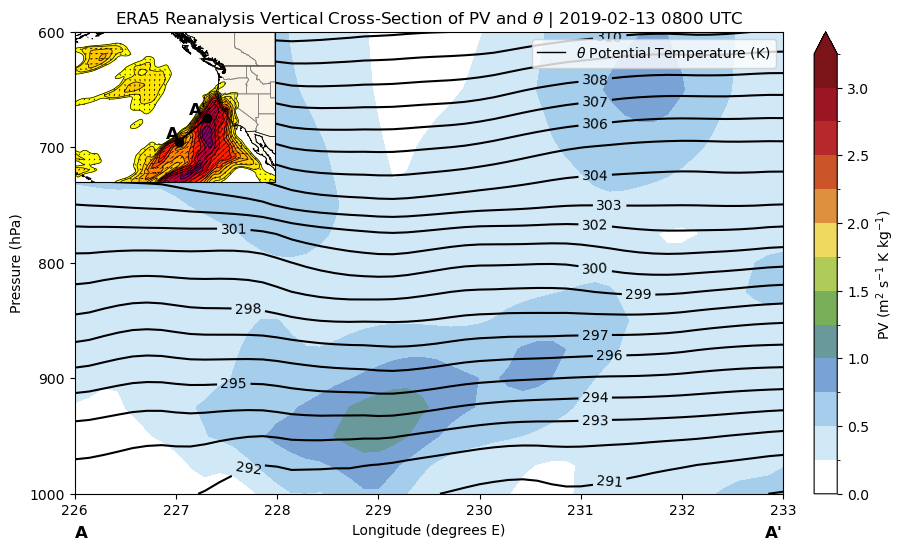

Time taken for iteration 8: 15.93 seconds


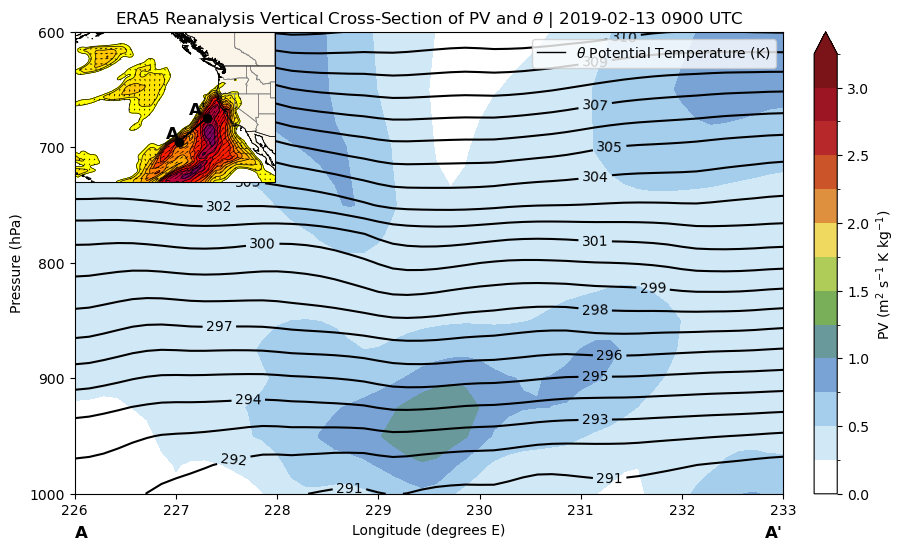

Time taken for iteration 9: 15.29 seconds


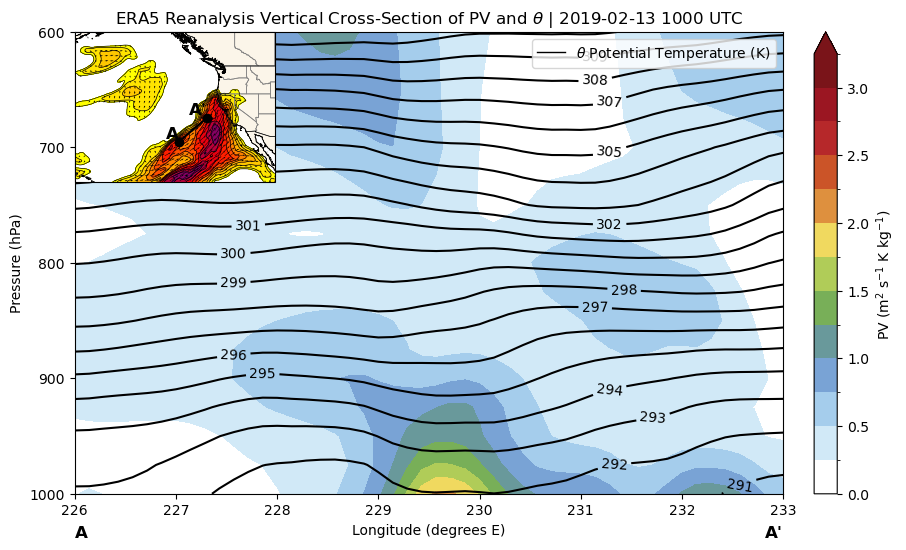

Time taken for iteration 10: 14.94 seconds


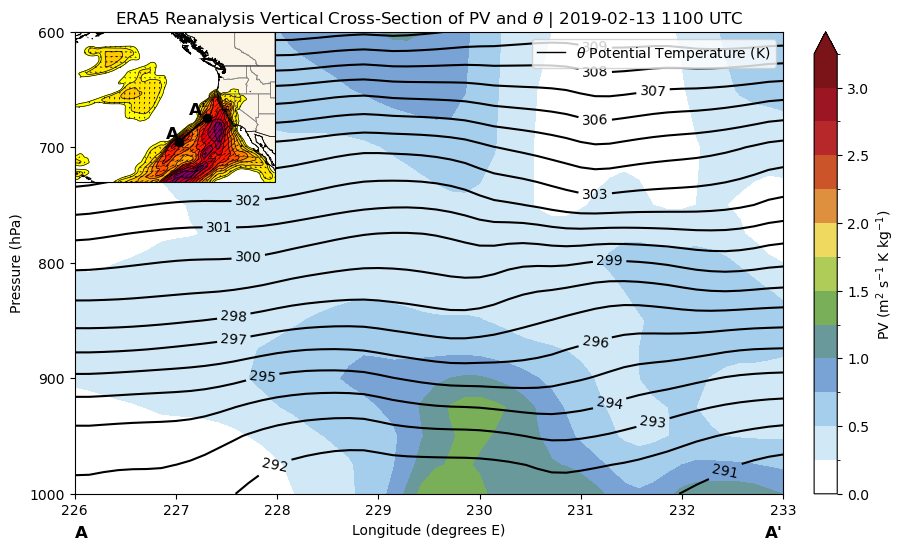

Time taken for iteration 11: 14.93 seconds


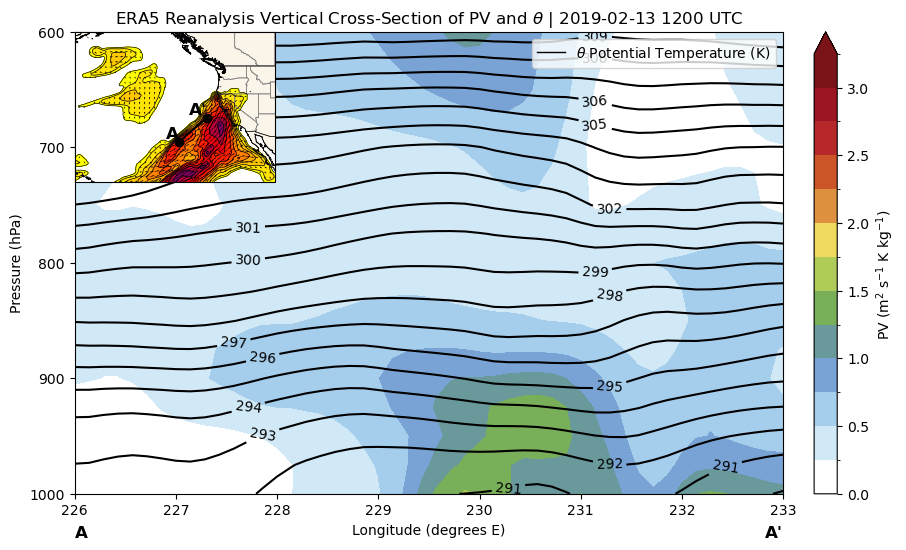

Time taken for iteration 12: 16.12 seconds


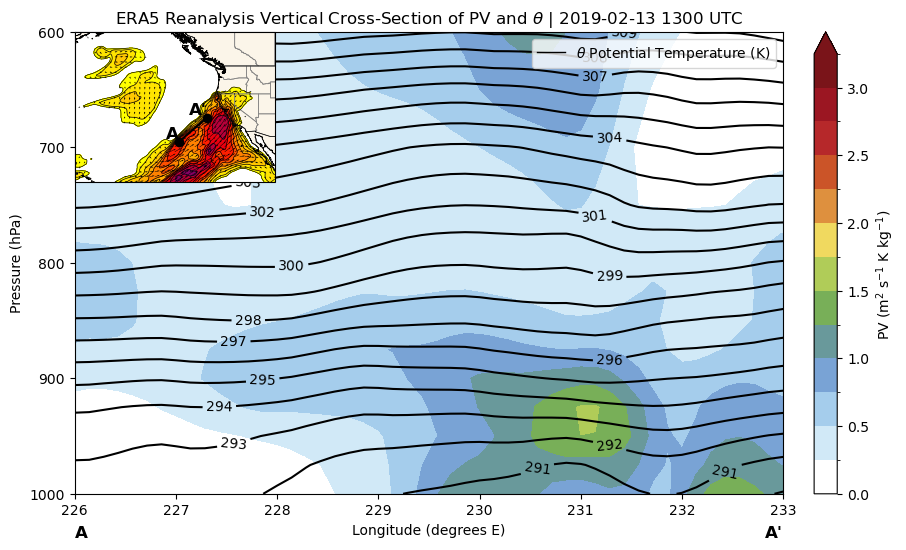

Time taken for iteration 13: 15.91 seconds


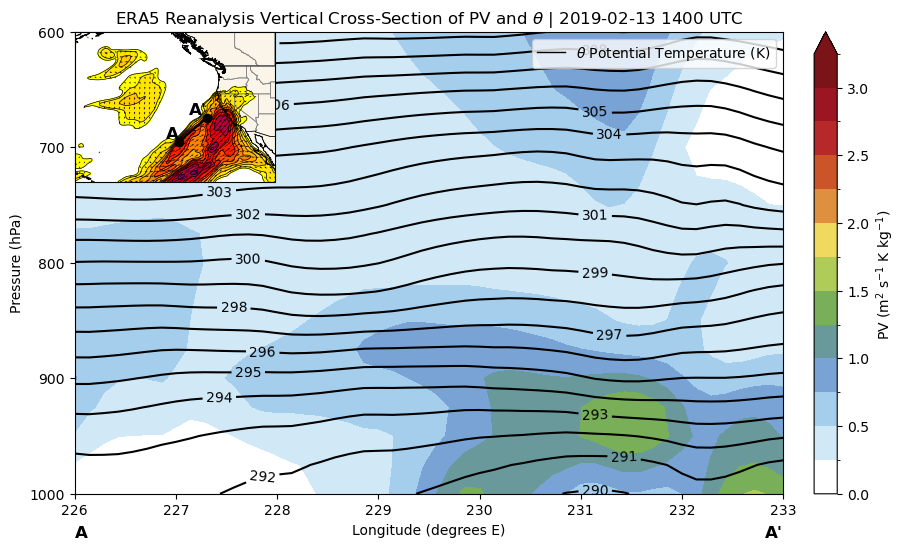

Time taken for iteration 14: 14.70 seconds


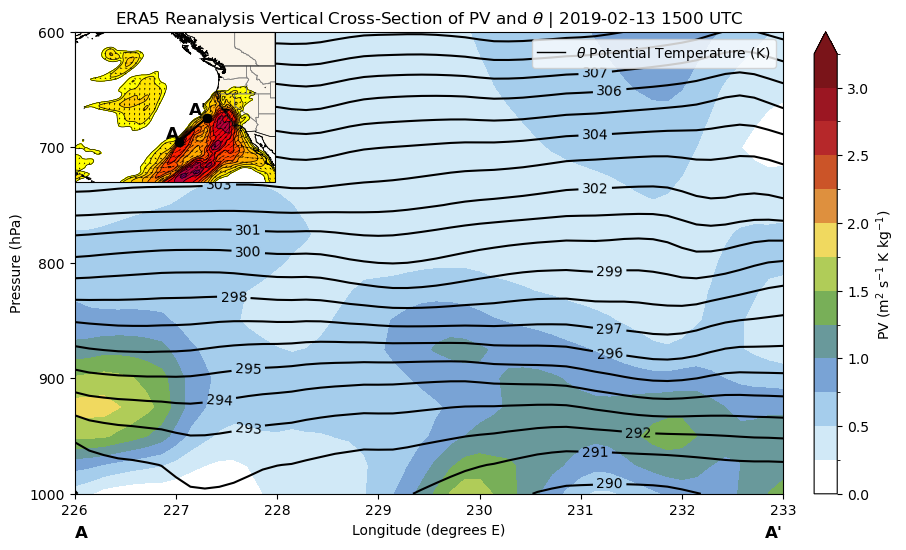

Time taken for iteration 15: 14.58 seconds


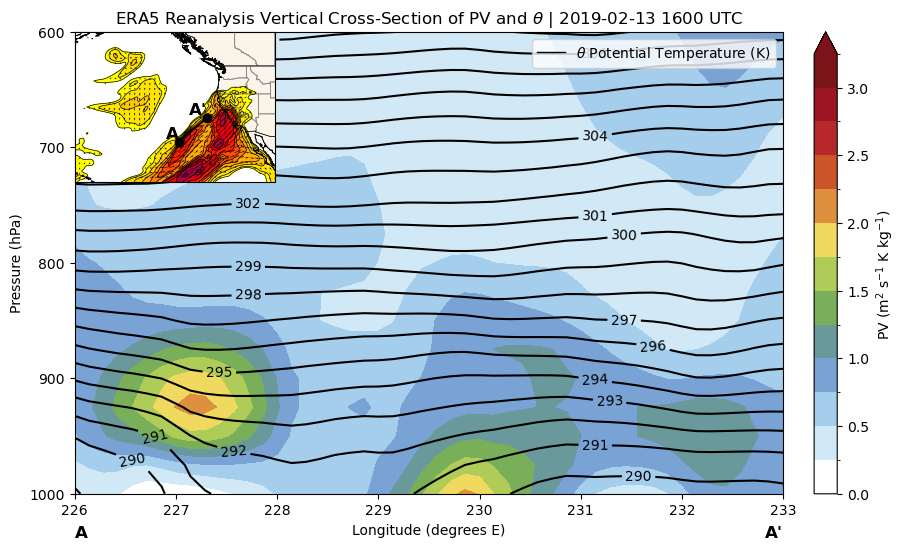

Time taken for iteration 16: 14.91 seconds


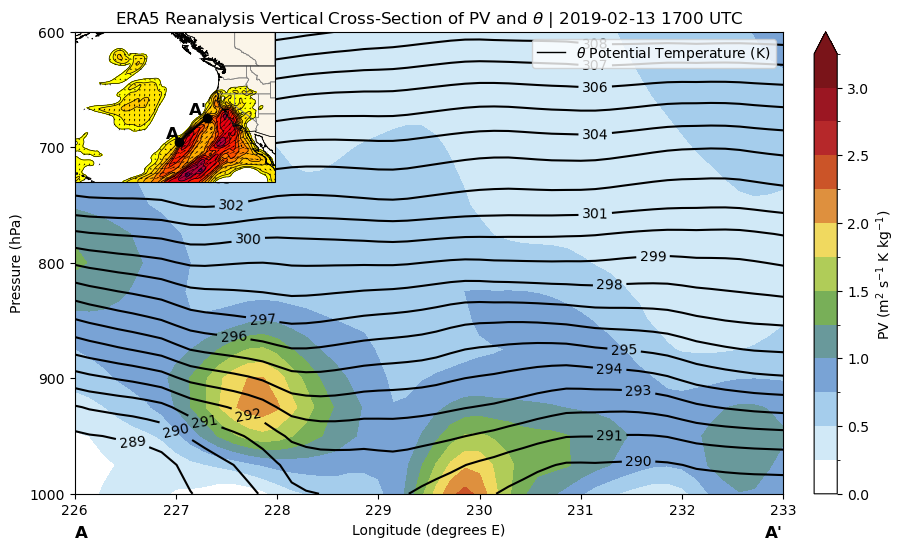

Time taken for iteration 17: 15.00 seconds


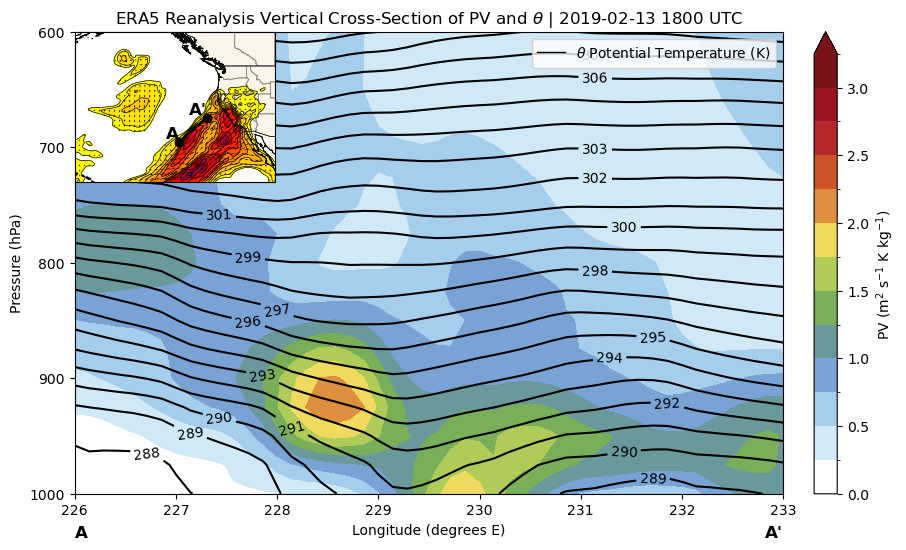

Time taken for iteration 18: 15.58 seconds


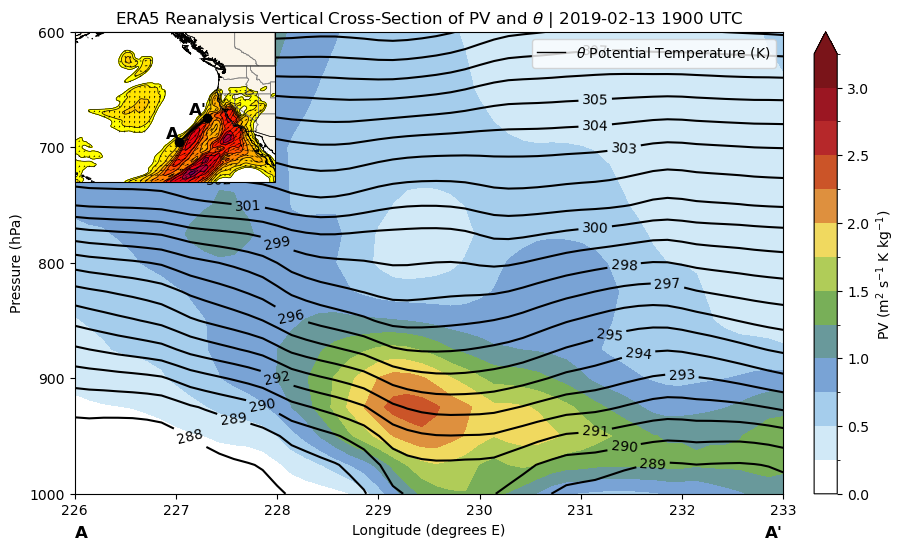

Time taken for iteration 19: 14.42 seconds


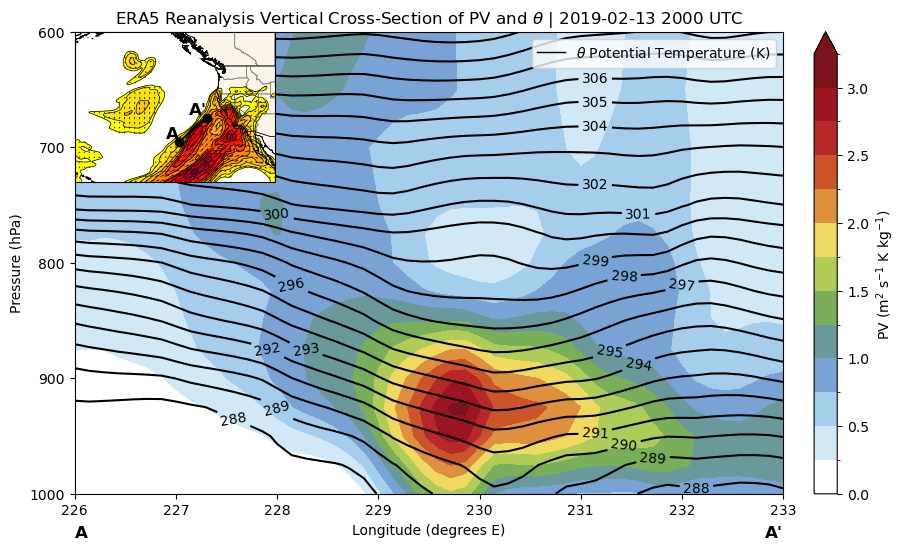

Time taken for iteration 20: 14.89 seconds


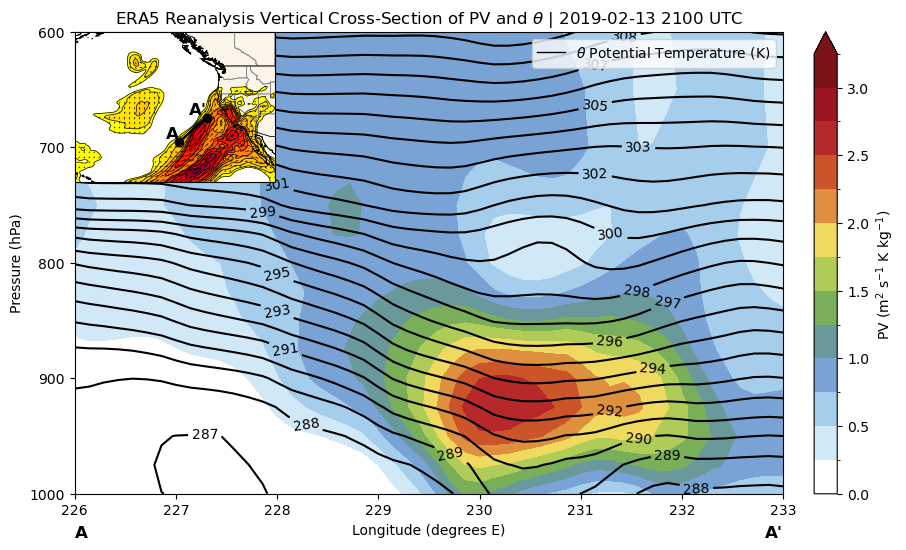

Time taken for iteration 21: 14.73 seconds


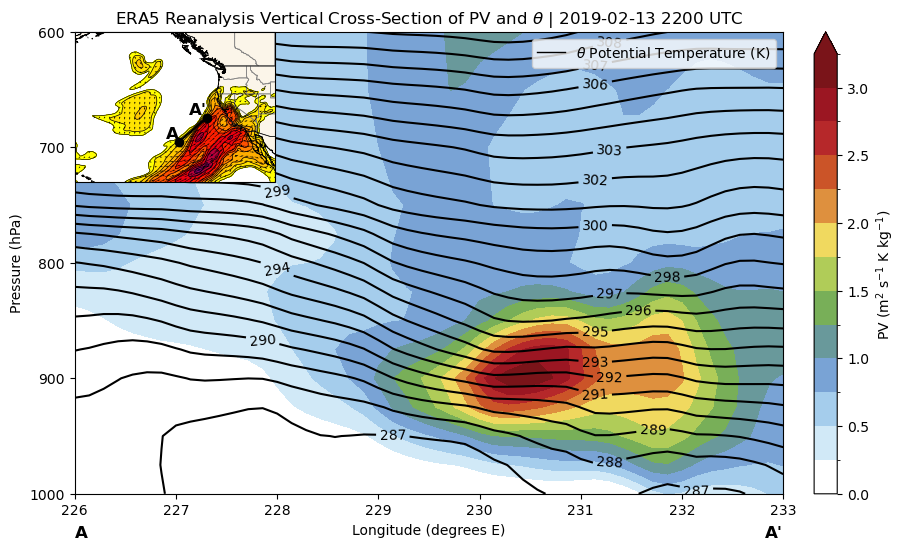

Time taken for iteration 22: 15.67 seconds


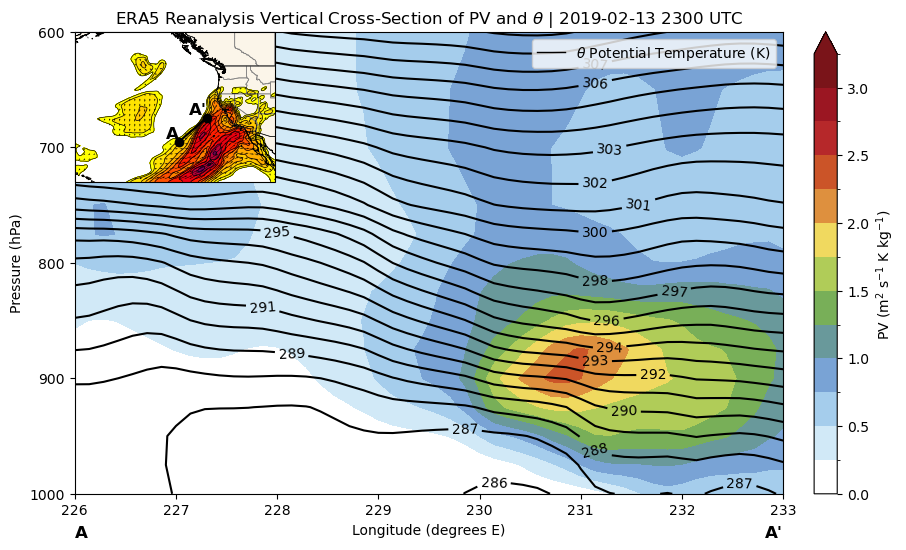

Time taken for iteration 23: 14.44 seconds
Cross-sections completed.


In [8]:
if __name__ == '__main__':
    year = 2019
    month = 2
    first_day = 13
    last_day = first_day
    directions = {'North': 55, 
                'East': 250, 
                'South': 20, 
                'West': 200} # units: degrees North, degrees East
    start_point = (30, 360 - 134) # units: degrees North, degrees East
    end_point = (36, 360 - 127) # units: degrees North, degrees East
    g = 9.81 # units: m/s^2

    print("="*50)
    print("Loading datasets...")
    ds_pl, ds_sfc, ds_lsm = load_datasets(year=year, month=month, start_day=first_day, end_day=last_day, start_hour=0, end_hour=23)
    print("Datasets loaded successfully.")
    print("="*50)

    print("Making cross-sections...")
    print("="*50)
    theta_pv_cross_section(start_point, end_point, ds_pl, directions, g)
    print("Cross-sections completed.")
    print("="*50)